In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import torch.autograd as autograd   

import torch
import pandas as pd

from scipy.interpolate import LinearNDInterpolator
device1 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device2 = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print("Device 1: ",device1)
print("Device 2: ",device2)

Device 1:  cuda:0
Device 2:  cuda:1


In [2]:
R0 = 5.36 #mm 5.36
Rs = 19 #mm
mu_vis = 0.3  
mu = 0.3 #Friction Coefficient (not viscosity)
delta = 0.5
A = 6.41 #For slip factor
pi = np.pi


Omega = 900 #rpm
V = 2 #mm/s



F = 0.67 #mm
rho = 2700 * 1e-6 #g/mm3
k_B = 1.380649*1e-23 #J/K
R = 8.314 #J/(K.mol)
E_a = 205000 #J/mol #Q
alpha_sig = 52 #mm^2/(kN)
# A = np.exp(27.78)
log_A = 27.78
n = 3.49

k = 0.167 #Thermal Conductivity #W/(mmK)
c_p = 0.897 #J/gK 
alpha_m = k/(rho*c_p)
T_a = 298.0


k_t = 0.0176 #W/(mmK)
c_p_t = 0.46 #J/gk
rho_t = 7750 * 1e-6 #g/mm3
alpha_t = k_t/(rho_t*c_p_t)

h_sides = 5*1e-6 #W/mm^2K
C_bot = 0.15*1e-6 #W/mm^2K^3

eeta = alpha_m/(alpha_m+alpha_t)

lb_xyz_uvw = np.array([-50.0,-20.0,-3.0])
ub_xyz_uvw = np.array([50.0,20.0,0.0])


lb_xyz = np.array([-50.0,-20.0,-3.0])
ub_xyz = np.array([50.0,20.0,0.0])


In [3]:
folder_main = '/home/smartlab/Documents/jupyterNB/raghav/Projects_git_summer2024/PINN_AFSD/Code_Final_Sept2024/AFSD_PINN/Experimental_Comparison_Only/ExperimentalData_and_Plots/'
# filename = 'Models_Trained_AFSD_Exp_2mms_z1mm_300rpm_2mms_8.pt'
orig_coPINN_ptname = 'AFSD_Exp_'+str(Omega)+'rpm_'+str(V)+'mms.pt'
calib_coPINN_ptname = 'AFSD_Exp_calib_'+str(Omega)+'rpm_'+str(V)+'mms.pt'
fvm_filename = 'Exponential_'+str(Omega)+'_'+str(V)+'mms.mat'

sheet_name  = str(Omega)+'rpm_'+str(V)+'mms'
data_exp = pd.read_excel("Experimental_Data_Full.xlsx",sheet_name=sheet_name,header = None)
data_exp= pd.DataFrame.to_numpy(data_exp)

In [4]:
from Seq_Model_Parallel_600 import coupled_PINN

layers1 = np.array([3,50,50,50,4]) #9 hidden layers
layers2 = np.array([3,50,50,50,1]) #9 hidden layers
# layers = np.array([3,50,50,50,5])
# layers = np.array([3,64,64,64,1])
model_coPINN = coupled_PINN(layers1,layers2,device1,device2,lb_xyz,ub_xyz)
model_calib_coPINN = coupled_PINN(layers1,layers2,device1,device2,lb_xyz,ub_xyz)

model_coPINN.load_state_dict(torch.load(folder_main + orig_coPINN_ptname))
model_calib_coPINN.load_state_dict(torch.load(folder_main + calib_coPINN_ptname),strict=False)

#Testing with FVM data
fvm_data = loadmat('/home/smartlab/Documents/jupyterNB/raghav/Projects_git_summer2024/Data/AFSD_Nikhil/' + fvm_filename)

u_fvm = fvm_data['u_star']
v_fvm = fvm_data['v_star']
w_fvm = fvm_data['w_star']

u_fvm = (u_fvm[0:-1,:,:] + u_fvm[1:,:,:])/2
v_fvm = (v_fvm[:,0:-1,:] + v_fvm[:,1:,:])/2
w_fvm = (w_fvm[:,:,0:-1] + w_fvm[:,:,1:])/2


# Res_v_fvm = np.sqrt(np.square(u_fvm) + np.square(v_fvm) + np.square(w_fvm))
T_fvm = fvm_data['T']
# sigma_e_fvm = fvm_data['effectivestress']
# eps_e_fvm = fvm_data['effstrrate']
# mu_vis_fvm = fvm_data['mu']

Sequentialmodel(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=4, bias=True)
  )
)
Sequentialmodel(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)
Sequentialmodel(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=4, bias=True)
  )
)
Sequentialmodel(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=

/home/smartlab/anaconda3/envs/raghav/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [5]:
# PLOTTING
[x_min,y_min,z_min] = lb_xyz
[x_max,y_max,z_max] = ub_xyz

x_min = -8.0
x_max = 8.0

z_min = -1.0
z_max = 0.0

x = np.linspace(x_min,x_max,40).reshape(-1,1)
# y = np.linspace(y_min,y_max,200).reshape(-1,1)
y = 20.0
z = np.linspace(z_min,z_max,5).reshape(-1,1)
# z = -0.4
X,Y,Z = np.meshgrid(x,y,z)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
Z = Z.flatten('F').reshape(-1,1)

xyz = np.hstack((X,Y,Z))
xyz_test_tensor = torch.from_numpy(xyz).float().to(device1)

# uvwp = model_PINN.PINN_uvw.forward(xyz_test_tensor).cpu().detach().numpy()
T_coPINN = model_coPINN.PINN_T.forward(xyz_test_tensor.to(device2)).cpu().detach().numpy()
T_calib_coPINN = model_calib_coPINN.PINN_T.forward(xyz_test_tensor.to(device2)).cpu().detach().numpy()

T_coPINN_plot = np.flip(T_coPINN.reshape(5,40),axis = 0)
T_calib_coPINN_plot = np.flip(T_calib_coPINN.reshape(5,40),axis =0)

In [6]:
x_real = np.linspace(x_min,x_max,17).reshape(-1,1)
# x_fvm = np.linspace(x_min,x_max,40).reshape(-1,1)
# plt.plot(x_fvm,np.mean(T_fvm[105:145,99,:4],axis = 1))
T_fvm_plot = np.flip(T_fvm[105:145,99,:5],axis = 1)

Text(0.5, 1.0, '$\\omega$ = 900RPM; $V$ = 2mm/s')

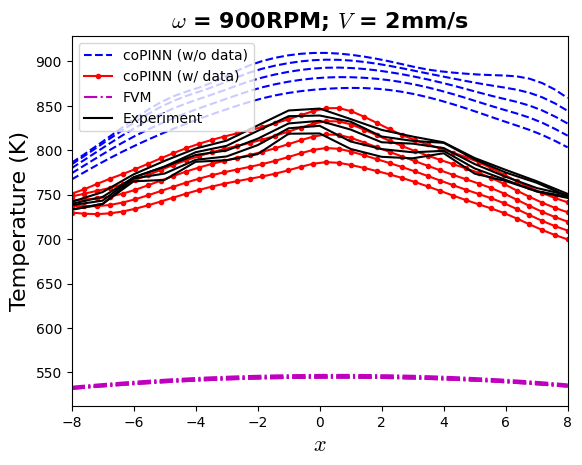

In [7]:
fig,ax = plt.subplots()

ax.plot(x,np.flip(T_coPINN_plot[0,:]),'b--',label='coPINN (w/o data)')
ax.plot(x,np.flip(T_coPINN_plot[1,:]),'b--')
ax.plot(x,np.flip(T_coPINN_plot[2,:]),'b--')
ax.plot(x,np.flip(T_coPINN_plot[3,:]),'b--')
ax.plot(x,np.flip(T_coPINN_plot[4,:]),'b--')

ax.plot(x,np.flip(T_calib_coPINN_plot[0,:]),'r.-',label='coPINN (w/ data)')
ax.plot(x,np.flip(T_calib_coPINN_plot[1,:]),'r.-')
ax.plot(x,np.flip(T_calib_coPINN_plot[2,:]),'r.-')
ax.plot(x,np.flip(T_calib_coPINN_plot[3,:]),'r.-')
ax.plot(x,np.flip(T_calib_coPINN_plot[4,:]),'r.-')

x_fvm = np.linspace(x_min,x_max,40).reshape(-1,1)
ax.plot(x_fvm,T_fvm_plot[:,0],'m-.',label = 'FVM')
ax.plot(x_fvm,T_fvm_plot[:,1],'m-.')
ax.plot(x_fvm,T_fvm_plot[:,2],'m-.')
ax.plot(x_fvm,T_fvm_plot[:,3],'m-.')
ax.plot(x_fvm,T_fvm_plot[:,4],'m-.')

ax.plot(x_real,data_exp[:,0],'k',label = 'Experiment')
ax.plot(x_real,data_exp[:,1],'k')
ax.plot(x_real,data_exp[:,2],'k')
ax.plot(x_real,data_exp[:,3],'k')
ax.plot(x_real,data_exp[:,4],'k')


ax.legend(loc = 2)
ax.set_xlim([-8,8])
ax.set_xlabel('$x$',math_fontfamily = 'cm',fontsize = 16)
ax.set_ylabel('Temperature (K)',fontsize = 16)

ax.set_title('$\omega$ = '+str(Omega)+'RPM; $V$ = ' + str(V)+'mm/s',fontsize = 16,fontweight = 'bold',math_fontfamily = 'cm')

In [8]:
from scipy.interpolate import CubicSpline
#RMSE Calculations
[x_min,y_min,z_min] = lb_xyz
[x_max,y_max,z_max] = ub_xyz



T_fvm_interp = np.zeros((17,5))
for i in range(5):
  
    spl = CubicSpline(x_fvm.reshape(-1,), T_fvm_plot[:,i])
    # T_fvm_interp[:,i] = np.interp(x_real.reshape(-1,), x_fvm.reshape(-1,), T_fvm_plot[:,i])
    T_fvm_interp[:,i] = spl(x_real.reshape(-1,))

x_min = -8.0
x_max = 8.0

z_min = -1.0
z_max = 0.0

x = np.linspace(x_min,x_max,17).reshape(-1,1)
# y = np.linspace(y_min,y_max,200).reshape(-1,1)
y = 20.0
z = np.linspace(z_min,z_max,5).reshape(-1,1)
# z = -0.4
X,Y,Z = np.meshgrid(x,y,z)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
Z = Z.flatten('F').reshape(-1,1)

xyz = np.hstack((X,Y,Z))
xyz_test_tensor = torch.from_numpy(xyz).float().to(device1)

# uvwp = model_PINN.PINN_uvw.forward(xyz_test_tensor).cpu().detach().numpy()
T_coPINN = model_coPINN.PINN_T.forward(xyz_test_tensor.to(device2)).cpu().detach().numpy()
T_calib_coPINN = model_calib_coPINN.PINN_T.forward(xyz_test_tensor.to(device2)).cpu().detach().numpy()

T_coPINN_RMSE = np.transpose(np.flip(T_coPINN.reshape(5,17),axis = 0))
T_calib_coPINN_RMSE = np.transpose(np.flip(T_calib_coPINN.reshape(5,17),axis = 0))


In [9]:
def RMSE(a,b):
    return np.sqrt(np.mean(np.square(a-b)))

def MAE(a,b):
    return np.mean(np.abs(a-b))


def corr(a,b):
    return np.corrcoef(a.reshape(-1,),b.reshape(-1,))[0,1]

print("RMSE FVM = ",RMSE(T_fvm_interp,data_exp))
print("RMSE coPINN = ",RMSE(T_coPINN_RMSE,data_exp))
print("RMSE Calib coPINN = ",RMSE(T_calib_coPINN_RMSE,data_exp))

print("")
print("Corr FVM = ",corr(T_fvm_interp,data_exp))
print("Corr coPINN = ",corr(T_coPINN_RMSE,data_exp))
print("Corr Calib coPINN = ",corr(T_calib_coPINN_RMSE,data_exp))


# print("")
# print("MAE FVM = ",MAE(T_fvm_interp,data_exp))
# print("MAE coPINN = ",MAE(T_coPINN_RMSE,data_exp))
# print("MAE Calib coPINN = ",MAE(T_calib_coPINN_RMSE,data_exp))

RMSE FVM =  248.51171263548804
RMSE coPINN =  71.05493430469221
RMSE Calib coPINN =  18.318229379352946

Corr FVM =  0.9594999585865294
Corr coPINN =  0.8045562075682797
Corr Calib coPINN =  0.9435651081570079
